In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from cleaning import *

In [4]:
FILEPATH = "selected_df - All.csv"
df = pd.read_csv(FILEPATH,
                 index_col=0,
                 header=[1]).reset_index()
df.head()

,index,titles,ratings,reviewer,reviews,english,dates,replies,reply_dates,clean_review,...,Carrefour,Other brand,reimbursement,clean_BE,clean_PD,clean_DM,clean_AS,summary,top_3,proper_n
0,1,Mais ou est ma commande???,1,todo,"Commande N° 609249735,toujours non livrée,pass...",NaN,2023-02-07T17:39:04.000Z,"Bonjour, nous vous informons que nous avons pr...",2023-02-08T09:48:06.000Z,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Cela fait plusieurs semaines même plus…,1,todo,Magasin de Carrefour Trans en Provence 83\nCel...,NaN,2023-02-06T14:48:53.000Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Commande Deliveroo annulé !,1,todo,Commande Deliveroo passé ce jour sans suite ca...,NaN,2023-02-08T10:54:56.000Z,"Bonjour, Pouvez-vous nous communiquer vos prén...",2023-02-08T10:17:23.000Z,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,une honte cette société qu'utilise…,1,todo,une honte cette société qu'utilise Carrefour p...,NaN,2023-02-04T18:29:49.000Z,"Bonjour, pourriez-vous nous communiquer votre ...",2023-02-05T08:17:54.000Z,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Nous sommes passer en caisse N,1,todo,Nous sommes passer en caisse N : 12\n28/01/202...,NaN,2023-02-05T14:36:40.000Z,"Bonjour, Pouvez-vous nous préciser le magasin ...",2023-02-06T08:30:25.000Z,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Original shape: (2000, 36)
Selected shape: (276, 36)
Unselected shape: (1724, 36)


/Users/carlosito/Library/CloudStorage/OneDrive-Personal/Personal Document/Hexamind/hexamind_code/Carrefour/Clustering/OneShotClassifier/cleaning.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['clean_BE'] = np.any(selected_df.loc[: ,BE_subclass], axis=1)
/Users/carlosito/Library/CloudStorage/OneDrive-Personal/Personal Document/Hexamind/hexamind_code/Carrefour/Clustering/OneShotClassifier/cleaning.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['clean_PD'] = np.any(selected_

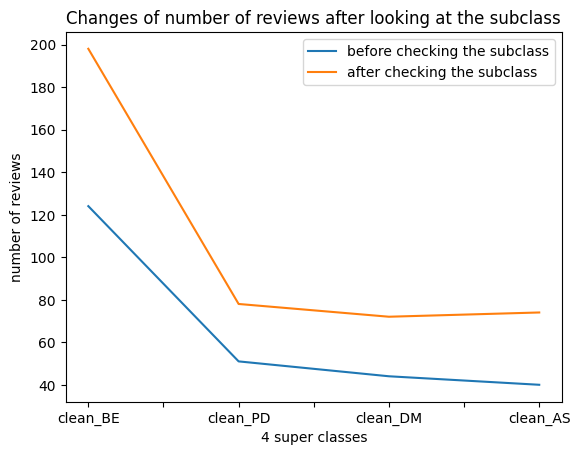

In [5]:
label_df, unlabel_df = binary_transform(df)

In [6]:
print(label_df.shape)
print(unlabel_df.shape)

(276, 36)
(1724, 36)


# 2/3 Train Test split

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix, f1_score, accuracy_score, hamming_loss


from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression

In [249]:
X = label_df.combined_reviews
y = label_df.loc[: , ['clean_BE' , 'clean_PD', 'clean_DM', 'clean_AS']]

In [250]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y,
                                                              train_size=0.7,
                                                              random_state=42)

In [251]:
count_vectorizer = CountVectorizer(analyzer='word',
                                   lowercase=False,
                                   max_df= 20)
X_train = count_vectorizer.fit_transform(X_train_text)
X_test = count_vectorizer.transform(X_test_text)

print(X_train.shape, X_test.shape)

(193, 3620) (83, 3620)


In [238]:
X_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [239]:
from sklearn.model_selection import GridSearchCV
parameters = {'penalty': [None, 'l2'], 
              'class_weight': [None, 'balanced']}


clf = GridSearchCV(MultiOutputClassifier(LogisticRegression(), 
                                         param_grid = parameters,
                                         scoring='f1_macro'))


TypeError: MultiOutputClassifier.__init__() got an unexpected keyword argument 'param_grid'

In [240]:
clf = MultiOutputClassifier(LogisticRegression()).fit(X_train, y_train)

In [241]:
prediction = clf.predict(X_test)
print(classification_report(y_true = y_test,
                            y_pred = prediction))
print(accuracy_score(y_true = y_test,
                      y_pred = prediction))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        58
           1       0.87      0.71      0.78        38
           2       0.95      0.61      0.74        33
           3       1.00      0.54      0.70        35

   micro avg       0.89      0.71      0.79       164
   macro avg       0.92      0.68      0.77       164
weighted avg       0.91      0.71      0.79       164
 samples avg       0.86      0.77      0.79       164

0.5943396226415094


/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [242]:
print(multilabel_confusion_matrix(y_true = y_test,
                      y_pred = prediction))

[[[39  9]
  [ 7 51]]

 [[64  4]
  [11 27]]

 [[72  1]
  [13 20]]

 [[71  0]
  [16 19]]]


In [243]:
clf = ClassifierChain(LogisticRegression()).fit(X_train, y_train)
prediction = clf.predict(X_test)
print(classification_report(y_true = y_test,
                            y_pred = prediction))
print(accuracy_score(y_true = y_test,
                      y_pred = prediction))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        58
           1       0.89      0.66      0.76        38
           2       0.95      0.64      0.76        33
           3       0.95      0.54      0.69        35

   micro avg       0.89      0.71      0.79       164
   macro avg       0.91      0.68      0.77       164
weighted avg       0.90      0.71      0.78       164
 samples avg       0.87      0.77      0.79       164

0.6132075471698113


/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [244]:
clf = ClassifierChain(RandomForestClassifier(max_depth = 10,
                                             max_features = 'log2')).fit(X_train, y_train)
prediction = clf.predict(X_test)
print(classification_report(y_true = y_test,
                            y_pred = prediction))
print(accuracy_score(y_true = y_test,
                      y_pred = prediction))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72        58
           1       1.00      0.05      0.10        38
           2       0.00      0.00      0.00        33
           3       1.00      0.06      0.11        35

   micro avg       0.58      0.38      0.46       164
   macro avg       0.64      0.28      0.23       164
weighted avg       0.64      0.38      0.30       164
 samples avg       0.57      0.43      0.47       164

0.3113207547169811


/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this be

# Now will try to plot that curve

In [252]:
n_samples = [8, 16, 32, 64 , 128, 193]

f1_score_record = []
accuracy_record = []
hamming_loss_record = []
for n in n_samples:
    selected_X_train_text = X_train_text[: n] #slice the training text based on the batch size
    count_vectorizer = CountVectorizer(analyzer='word', #call new countVectorizer
                                   lowercase=False,
                                   max_df= 20)
    selected_X_train = count_vectorizer.fit_transform(selected_X_train_text) 
    selected_X_test = count_vectorizer.transform(X_test_text) #this will be always 83
    assert selected_X_test.shape[0] == 83
    
    selected_y_train = y_train[:n]
    
    clf = MultiOutputClassifier(LogisticRegression()).fit(selected_X_train, selected_y_train)
    
    prediction = clf.predict(selected_X_test)
    
    f1_score_record.append(f1_score(y_true = y_test,
                                    y_pred = prediction,
                                    average = 'macro'))
    
    accuracy_record.append(accuracy_score(y_true = y_test,
                                    y_pred = prediction))
    
    hamming_loss_record.append(hamming_loss(y_true = y_test,
                                    y_pred = prediction))
    
    
    

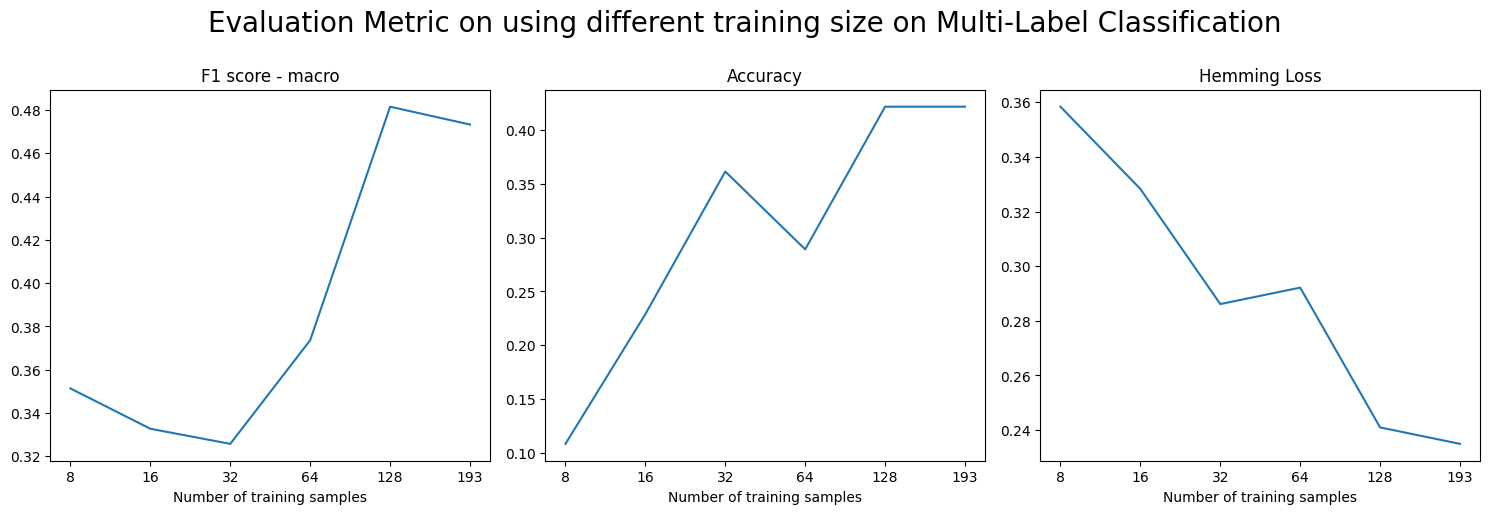

In [253]:
fig, axes = plt.subplots(1,3, figsize = (15,5))

sns.lineplot(data = f1_score_record,
             ax = axes[0])

sns.lineplot(data = accuracy_record,
             ax = axes[1])

sns.lineplot(data = hamming_loss_record,
             ax = axes[2])

fig.suptitle('Evaluation Metric on using different training size on Multi-Label Classification\n',
             fontsize = 20)
fig.tight_layout()

axes[0].set_title('F1 score - macro')
axes[1].set_title('Accuracy')
axes[2].set_title('Hemming Loss')

axes[0].set_xlabel('Number of training samples')
axes[1].set_xlabel('Number of training samples')
axes[2].set_xlabel('Number of training samples')

axes[0].set_xticks(range(6), n_samples )
axes[1].set_xticks(range(6), n_samples )
axes[2].set_xticks(range(6), n_samples )
plt.show()

In [15]:
print(classification_report(y_true = y_test,
                            y_pred = prediction))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        63
           1       0.67      0.18      0.29        22
           2       0.71      0.25      0.37        20
           3       0.86      0.26      0.40        23

   micro avg       0.76      0.58      0.65       128
   macro avg       0.75      0.41      0.47       128
weighted avg       0.75      0.58      0.59       128
 samples avg       0.75      0.64      0.66       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---

## Use CountVectorizer without stopwords

In [21]:
# opening the file in read mode
my_file = open("/Users/carlosito/Library/CloudStorage/OneDrive-Personal/Personal Document/Hexamind/hexamind_code/Carrefour/french_stopword.txt" , 'r')
  
# reading the file
data = my_file.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
french_stopwords_list = data.replace('\n', ' ').split(" ")
  
# # printing the data
print(french_stopwords_list[:5])
my_file.close()

['a', 'abord', 'absolument', 'afin', 'ah']


In [254]:
selected_X_test

<83x3620 sparse matrix of type '<class 'numpy.int64'>'
	with 2094 stored elements in Compressed Sparse Row format>

In [255]:
n_samples = [8, 16, 32, 64 , 128, 193]

f1_score_record_without_stopword = []
accuracy_record_without_stopword = []
hamming_loss_record_without_stopword = []
for n in n_samples:
    selected_X_train_text = X_train_text[: n] #slice the training text based on the batch size
    count_vectorizer = CountVectorizer(analyzer='word', #call new countVectorizer
                                   lowercase=True,
                                   stop_words= french_stopwords_list )
    selected_X_train = count_vectorizer.fit_transform(selected_X_train_text) 
    selected_X_test = count_vectorizer.transform(X_test_text) #this will be always 83
    assert selected_X_test.shape[0] == 83
    
    selected_y_train = y_train[:n]
    
    clf = MultiOutputClassifier(LogisticRegression()).fit(selected_X_train, selected_y_train)
    
    prediction = clf.predict(selected_X_test)
    
    f1_score_record_without_stopword.append(f1_score(y_true = y_test,
                                    y_pred = prediction,
                                    average = 'macro'))
    
    accuracy_record_without_stopword.append(accuracy_score(y_true = y_test,
                                    y_pred = prediction))
    
    hamming_loss_record_without_stopword.append(hamming_loss(y_true = y_test,
                                    y_pred = prediction))
    

/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarn

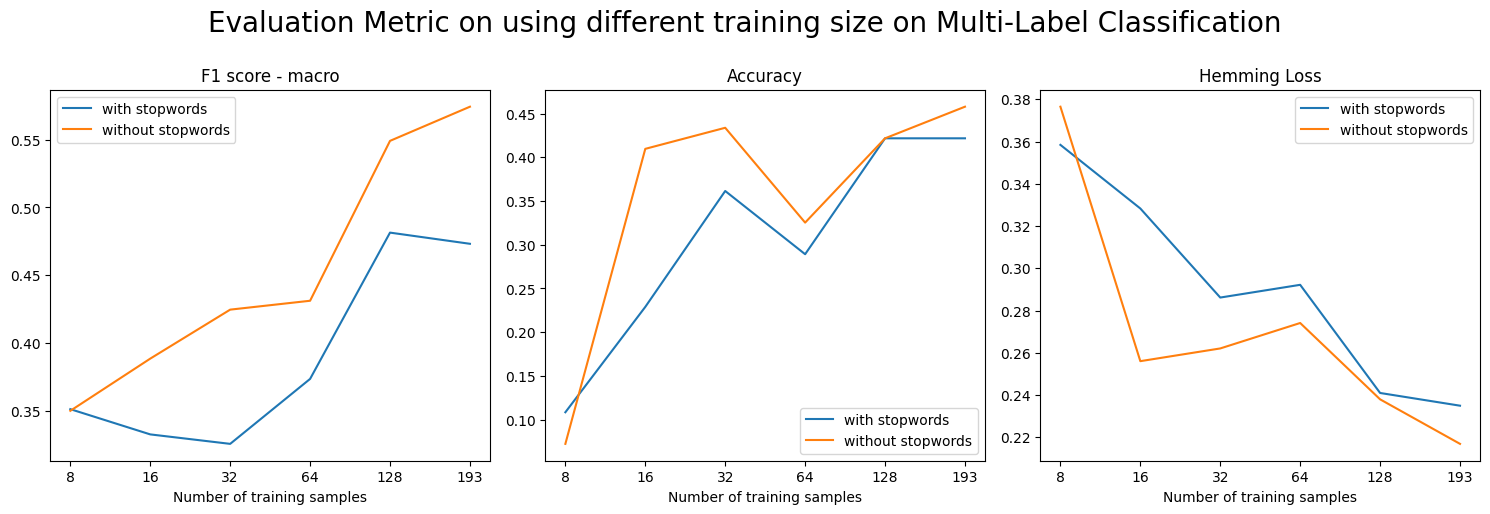

In [256]:
fig, axes = plt.subplots(1,3, figsize = (15,5))

sns.lineplot(data = f1_score_record,
             ax = axes[0], label = 'with stopwords')

sns.lineplot(data = accuracy_record,
             ax = axes[1], label = 'with stopwords')

sns.lineplot(data = hamming_loss_record,
             ax = axes[2], label = 'with stopwords')


sns.lineplot(data = f1_score_record_without_stopword,
             ax = axes[0], label = 'without stopwords')

sns.lineplot(data = accuracy_record_without_stopword,
             ax = axes[1], label = 'without stopwords')

sns.lineplot(data = hamming_loss_record_without_stopword,
             ax = axes[2], label = 'without stopwords')


fig.suptitle('Evaluation Metric on using different training size on Multi-Label Classification\n',
             fontsize = 20)
fig.tight_layout()

axes[0].set_title('F1 score - macro')
axes[1].set_title('Accuracy')
axes[2].set_title('Hemming Loss')

axes[0].set_xlabel('Number of training samples')
axes[1].set_xlabel('Number of training samples')
axes[2].set_xlabel('Number of training samples')

axes[0].set_xticks(range(6), n_samples )
axes[1].set_xticks(range(6), n_samples )
axes[2].set_xticks(range(6), n_samples )
plt.show()

In [257]:
print(classification_report(y_true = y_test,
                            y_pred = prediction))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83        63
           1       0.67      0.36      0.47        22
           2       0.77      0.50      0.61        20
           3       0.75      0.26      0.39        23

   micro avg       0.77      0.62      0.69       128
   macro avg       0.75      0.50      0.57       128
weighted avg       0.76      0.62      0.66       128
 samples avg       0.75      0.66      0.67       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
summary_df = pd.DataFrame( [ ["a" ,"b","c", "d"] , prediction.sum(axis = 0) , ['prediction without stopwords' for i in range(4)]]).T
summary_df.columns = ['class_name', 'count', 'type']

y_test_summary_df = pd.DataFrame( [ ["a" ,"b","c", "d"] , y_test.sum(axis = 0) , ['y_test' for i in range(4)]]).T
y_test_summary_df.columns = ['class_name', 'count', 'type']


In [77]:
y_test_summary_df

,class_name,count,type
0,a,63,y_test
1,b,22,y_test
2,c,20,y_test
3,d,23,y_test


In [78]:
test_plot = pd.concat([summary_df, y_test_summary_df])
test_plot

,class_name,count,type
0,a,69,prediction without stopwords
1,b,12,prediction without stopwords
2,c,13,prediction without stopwords
3,d,8,prediction without stopwords
0,a,63,y_test
1,b,22,y_test
2,c,20,y_test
3,d,23,y_test


<AxesSubplot: xlabel='class_name', ylabel='count'>

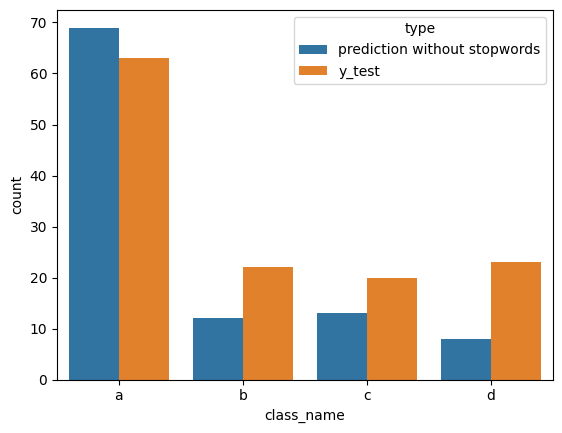

In [79]:
sns.barplot(data=test_plot, x= 'class_name', y ='count', hue = 'type')

In [17]:
BE_count = CountVectorizer()
label_df[label_df['clean_BE'] == 1]

,index,titles,ratings,reviewer,reviews,english,dates,replies,reply_dates,clean_review,...,Carrefour,Other brand,reimbursement,clean_BE,clean_PD,clean_DM,clean_AS,summary,top_3,proper_n
10,11,Autant l'hyper de ma ville est plus…,3,Poon,"Autant l'hyper de ma ville est plus complet, a...","As much the hyper of my city is more complete,...",2023-01-28T22:00:47.000Z,"Bonjour, effectivement, vos magasins de proxim...",2023-01-31T12:22:09.000Z,"Autant l'hyper de ma ville est plus complet, a...",...,False,False,False,1,0,0,0,NaN,NaN,NaN
14,15,Carrefour France,3,Poon,"Carrefour France, vous choisissez de mettre e...","Carrefour France, you choose to set up boxes w...",2023-01-25T11:25:11.000Z,"Bonjour, pourriez-vous nous communiquer plus d...",2023-01-25T12:44:28.000Z,"Carrefour France, vous choisissez de mettre e...",...,False,False,False,1,0,0,0,NaN,NaN,NaN
16,17,Carrefour Grand Var,2,Yves,Carrefour Grand Var : cela fait quelques moi q...,NaN,2023-01-17T05:00:41.000Z,"Bonjour, nous vous remercions pour votre signa...",2023-01-17T15:05:55.000Z,Carrefour Grand Var : cela fait quelques moi q...,...,False,False,False,1,0,0,0,NaN,NaN,NaN
19,20,Carrefour market très bien mais il…,3,Poon,Carrefour market Miramas très bien mais il n'e...,Carrefour Market Miramas very well but it is n...,2023-01-21T06:31:51.000Z,"Bonsoir, pourriez-vous nous apporter plus de p...",2023-01-21T07:55:55.000Z,Carrefour market Miramas très bien mais il n'e...,...,False,False,False,1,0,0,0,NaN,NaN,NaN
21,22,PUBLICITE MENSONGERE,1,Yves,je reçois ce matin un sms de carrefour me disa...,NaN,2023-01-12T08:29:08.000Z,"Bonjour, afin d'expertiser cette situation, no...",2023-01-13T14:48:32.000Z,je reçois ce matin un sms de carrefour me disa...,...,False,False,False,1,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961,1962,Aucun contact possible avec le SAV,1,Insaf,À l'heure ou j'écris j'en suis au 5eme appel c...,NaN,2014-09-12T14:27:00.000Z,NaN,NaN,À l'heure ou j'écris j'en suis au 5eme appel c...,...,True,False,False,1,0,1,1,NaN,NaN,NaN
1964,1965,"Publicité mensongère, site online inacceptable...",1,Insaf,des expériences similaires à la mienne ont déj...,NaN,2014-09-05T19:59:34.000Z,NaN,NaN,des expériences similaires à la mienne ont déj...,...,True,False,False,1,1,1,1,NaN,NaN,NaN
1968,1969,Produit défectueux et SAV lamentable,1,Insaf,J'ai reçu un produit défectueux et le SAV refu...,NaN,2014-08-07T10:04:22.000Z,NaN,NaN,J'ai reçu un produit défectueux et le SAV refu...,...,False,False,True,1,1,0,1,NaN,NaN,NaN
1972,1973,"inacceptable, mauvais service après-vente",1,All,Je fais toutes mes courses chaque semaine à ca...,NaN,2014-06-12T09:45:37.000Z,NaN,NaN,Je fais toutes mes courses chaque semaine à ca...,...,True,False,False,1,0,0,1,NaN,NaN,NaN


# Now let's augment the data by using `nlpAug`

In [80]:
import nlpaug.augmenter.word as naw

/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [108]:
text = 'No se que hacer'
aug = naw.SynonymAug(aug_src='wordnet', lang='spa')
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
No se que hacer
Augmented Text:
['No se que hacer']


In [137]:
text = label_df.combined_reviews.iloc[87]
aug = naw.SynonymAug(aug_src='wordnet', lang='fra' , aug_p= 0.5)
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
Concernant les couteaux Sabatier Concernant les couteaux Sabatier. Les magasins carrefour sont en rupture de stock depuis des semaines. Le service clientèle n'a de cesse de donner ce lien pour les reserver en ligne, mais la page web est une impasse.Aucune option n'est offerte afin de reserver un produit quelconque à cette page. Avis au service clientèle Carrefour: Merci de nous indiquer la marche à suivre si possible
Augmented Text:
["Concernant les couteaux Sabatier Concernant les couteaux Sabatier. Les magasins carrefour sont en rupture de réserve depuis des semaines. Le service clientèle n ' a de cesse de donner ce lien pour les reserver en ligne, mais la côté web est une cul. Aucune option n ' est offerte afin de reserver un produit quelconque à cette page. Avis au appareil clientèle Carrefour: Merci de nous indiquer la marche une suivre système international d'unités possible"]


## Augment on those small unbalanced clasess [1, 2, 3]

In [145]:
# belong to PD but not in BE
print(len(label_df[(label_df['clean_PD']== 1)  & (label_df['clean_BE'] != 1)  ]))
# belong to PD but not in BE)
print(len(label_df[(label_df['clean_DM']== 1)  & (label_df['clean_BE'] != 1)  ]))
# belong to AS but not in BE)
print(len(label_df[(label_df['clean_AS']== 1)  & (label_df['clean_BE'] != 1)  ]))

37
34
31


In [186]:
aug = naw.SynonymAug(aug_src='wordnet', lang='fra' , aug_p= 0.5)
def augment_text(original_text, augmentor = aug):
    augmented_text = aug.augment(original_text)
    return augmented_text[0]

In [187]:
augment_text("Je suis etudiant")

'Moi suis etudiant'

In [158]:
conditions = ( 
              ((label_df['clean_PD']== 1)  & (label_df['clean_BE'] != 1) ) |
              ((label_df['clean_DM']== 1)  & (label_df['clean_BE'] != 1) ) |
              ((label_df['clean_AS']== 1)  & (label_df['clean_BE'] != 1) )
              ) 


# label_df[(label_df['clean_AS']== 1)  & (label_df['clean_BE'] != 1)  ]

In [174]:
augmented_df =  label_df[conditions].copy(deep =True)
augmented_df.shape

(74, 36)

<BarContainer object of 4 artists>

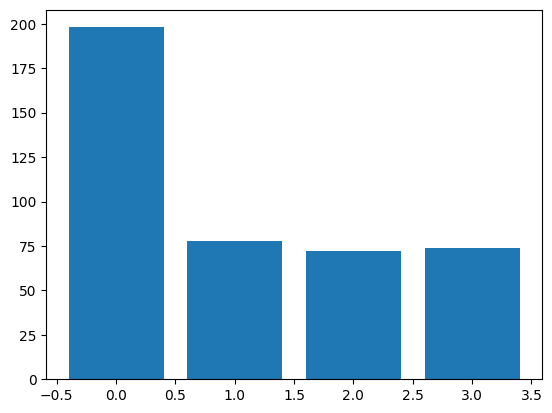

In [172]:
# Count the original distribution of each topics
plt.bar([0,1,2,3] , label_df.iloc[: ,-7: -3].sum(axis= 0))

### Let's replace the combined reviews columns with the augmented so it is easier to stack this augmented df with the original label_df

In [189]:
augmented_df['combined_reviews'] = augmented_df['combined_reviews'].apply(lambda x : augment_text(x))

In [191]:
assert augmented_df.shape[1] == label_df.shape[1]

In [203]:
new_df = pd.concat([label_df, augmented_df]).reset_index(drop=True)
new_df.head()

,index,titles,ratings,reviewer,reviews,english,dates,replies,reply_dates,clean_review,...,Carrefour,Other brand,reimbursement,clean_BE,clean_PD,clean_DM,clean_AS,summary,top_3,proper_n
0,11,Autant l'hyper de ma ville est plus…,3,Poon,"Autant l'hyper de ma ville est plus complet, a...","As much the hyper of my city is more complete,...",2023-01-28T22:00:47.000Z,"Bonjour, effectivement, vos magasins de proxim...",2023-01-31T12:22:09.000Z,"Autant l'hyper de ma ville est plus complet, a...",...,False,False,False,1,0,0,0,NaN,NaN,NaN
1,13,Livraison à domicile Orléans,4,Poon,"Pour d'obscures raisons, la livraison à domici...","For obscure reasons, the home delivery of Inte...",2023-01-29T14:50:15.000Z,"Bonjour, nous tenons à vous remercier pour vot...",2023-01-29T16:00:04.000Z,"Pour d'obscures raisons, la livraison à domici...",...,False,False,False,0,0,1,0,NaN,NaN,NaN
2,15,Carrefour France,3,Poon,"Carrefour France, vous choisissez de mettre e...","Carrefour France, you choose to set up boxes w...",2023-01-25T11:25:11.000Z,"Bonjour, pourriez-vous nous communiquer plus d...",2023-01-25T12:44:28.000Z,"Carrefour France, vous choisissez de mettre e...",...,False,False,False,1,0,0,0,NaN,NaN,NaN
3,17,Carrefour Grand Var,2,Yves,Carrefour Grand Var : cela fait quelques moi q...,NaN,2023-01-17T05:00:41.000Z,"Bonjour, nous vous remercions pour votre signa...",2023-01-17T15:05:55.000Z,Carrefour Grand Var : cela fait quelques moi q...,...,False,False,False,1,0,0,0,NaN,NaN,NaN
4,20,Carrefour market très bien mais il…,3,Poon,Carrefour market Miramas très bien mais il n'e...,Carrefour Market Miramas very well but it is n...,2023-01-21T06:31:51.000Z,"Bonsoir, pourriez-vous nous apporter plus de p...",2023-01-21T07:55:55.000Z,Carrefour market Miramas très bien mais il n'e...,...,False,False,False,1,0,0,0,NaN,NaN,NaN


Text(0.5, 1.0, 'After augmenting')

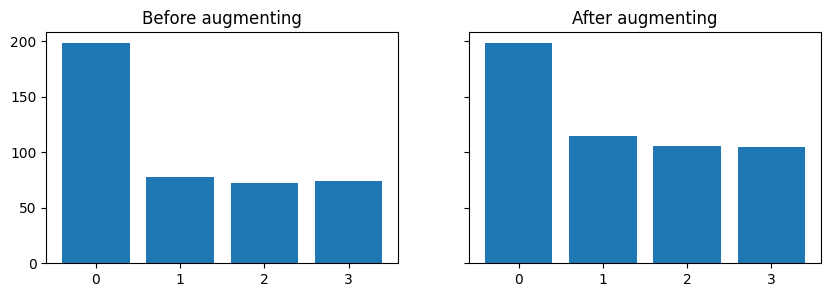

In [258]:
fig, axes = plt.subplots(1,2 , figsize = (10,3), sharey = True)

axes[0].bar([0,1,2,3] , label_df.iloc[: ,-7: -3].sum(axis= 0))
axes[0].set_title('Before augmenting')
axes[1].bar([0,1,2,3] , new_df.iloc[: ,-7: -3].sum(axis= 0))
axes[1].set_title('After augmenting')

## Train this new_df

In [259]:
X = new_df.combined_reviews
y = new_df.loc[: , ['clean_BE' , 'clean_PD', 'clean_DM', 'clean_AS']]

print(X.shape)

# we are NOT going to use this X_test/y_test  here because we must stick with the orignal 83 y_test
X_train_text, not_use_X_test_text, y_train, not_use_y_test = train_test_split(X, y,
                                                              train_size=0.7,
                                                              random_state=42)

(350,)


In [319]:
X_train_text.index

Int64Index([ 79, 116,  18, 223, 104, 271,  31, 254, 148, 180,
            ...
            214, 121, 349,  20, 188,  71, 106, 270, 348, 102],
           dtype='int64', length=244)

In [335]:
len(X_train_text)

244

In [333]:
count_sample = 0

for i in X_test_text:
    if i in X_train_text:
        count_sample +=1
    print(i)

Chouette personnel J’ai récemment fait mes courses au magasin de Fourmies.  Je me suis adressé au personnel en rayon pour deux ou trois questions. À chaque fois, le personnel était super agréable, très poli et serviable.  Une belle expérience qui donn envie de revenir ! Merci à vous !
Un commande maison et loisirs passée le… Un commande maison et loisirs passée le 19 novembre livrée " sous 2/3jours ouvrés" et depuis rien.....on va me rappeler, on ouvre des dossiers " pour demander aux services concernés" " on va solliciter des experts" et le temps passe sans réponse , sans information et sans actualisation.Ai-je les moyens de redépenser 260 euros ailleurs pour recommander mon article ? NONMépris et non respect du client au programme de décembre donc avec un cadeau en moins perdu dans la nature dommage.Il va falloir vous bouger Carrefour !
Magasin à fuir Magasin à fuir ! Personnel insultant et hautain, puis jamais cette enseigne. Après deux semaine de location d’un véhicule je me suis f

In [279]:
n_samples = [8, 16, 32, 64 , 128, 193, 244] # we add a new

def run_classifer(X_train_text, y_train,
                  X_test_text, y_test):

    f1_score_record = []
    accuracy_record = []
    hamming_loss_record = []
    for n in n_samples:
        selected_X_train_text = X_train_text[: n] #slice the training text based on the batch size
        count_vectorizer = CountVectorizer(analyzer='word', #call new countVectorizer
                                    lowercase=False,
                                    max_df= 20)
        selected_X_train = count_vectorizer.fit_transform(selected_X_train_text) 
        selected_X_test = count_vectorizer.transform(X_test_text) #this will be always 83
        assert selected_X_test.shape[0] == 83
        
        selected_y_train = y_train[:n]
        
        clf = MultiOutputClassifier(LogisticRegression()).fit(selected_X_train, selected_y_train)
        
        print('model pass')
        prediction = clf.predict(selected_X_test)
        
        f1_score_record.append(f1_score(y_true = y_test,
                                        y_pred = prediction,
                                        average = 'macro'))
        
        accuracy_record.append(accuracy_score(y_true = y_test,
                                        y_pred = prediction))
        
        hamming_loss_record.append(hamming_loss(y_true = y_test,
                                        y_pred = prediction))
    
    return {"f1_score" :f1_score_record,
            "acc": accuracy_record,
            "hamming_loss": hamming_loss_record,
            "model": clf,
            "vectorizer": count_vectorizer}

    
    
    

In [280]:
augmented_result = run_classifer(X_train_text, y_train,
                  X_test_text, y_test)

model pass
model pass
model pass
model pass
model pass
model pass
model pass


In [274]:
augmented_result

{'f1_score': [0.4388476107226107,
  0.47776263357658705,
  0.5564801621227955,
  0.6287831596697876,
  0.7103141344593089,
  0.7660269905533064,
  0.7912751073033331],
 'acc': [0.08433734939759036,
  0.3132530120481928,
  0.4819277108433735,
  0.5662650602409639,
  0.6265060240963856,
  0.6867469879518072,
  0.7108433734939759],
 'hamming_loss': [0.37650602409638556,
  0.2921686746987952,
  0.24096385542168675,
  0.18373493975903615,
  0.15963855421686746,
  0.11746987951807229,
  0.10240963855421686],
 'model': MultiOutputClassifier(estimator=LogisticRegression())}

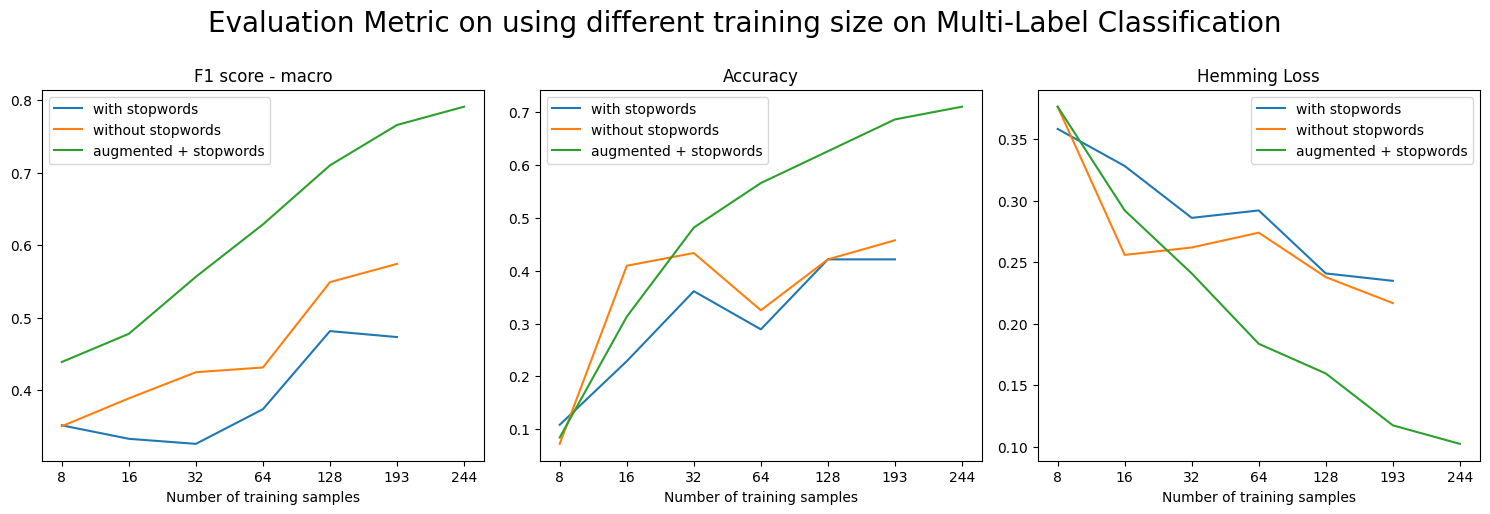

In [271]:
fig, axes = plt.subplots(1,3, figsize = (15,5))

sns.lineplot(data = f1_score_record,
             ax = axes[0], label = 'with stopwords')

sns.lineplot(data = accuracy_record,
             ax = axes[1], label = 'with stopwords')

sns.lineplot(data = hamming_loss_record,
             ax = axes[2], label = 'with stopwords')


sns.lineplot(data = f1_score_record_without_stopword,
             ax = axes[0], label = 'without stopwords')

sns.lineplot(data = accuracy_record_without_stopword,
             ax = axes[1], label = 'without stopwords')

sns.lineplot(data = hamming_loss_record_without_stopword,
             ax = axes[2], label = 'without stopwords')


sns.lineplot(data = augmented_result['f1_score'],
             ax = axes[0], label = 'augmented + stopwords')

sns.lineplot(data = augmented_result['acc'],
             ax = axes[1], label = 'augmented + stopwords')

sns.lineplot(data = augmented_result['hamming_loss'],
             ax = axes[2], label = 'augmented + stopwords')



fig.suptitle('Evaluation Metric on using different training size on Multi-Label Classification\n',
             fontsize = 20)
fig.tight_layout()

axes[0].set_title('F1 score - macro')
axes[1].set_title('Accuracy')
axes[2].set_title('Hemming Loss')

axes[0].set_xlabel('Number of training samples')
axes[1].set_xlabel('Number of training samples')
axes[2].set_xlabel('Number of training samples')

axes[0].set_xticks(range(7), n_samples )
axes[1].set_xticks(range(7), n_samples )
axes[2].set_xticks(range(7), n_samples )
plt.show()

In [276]:
augmented_result['model'].predict()

MultiOutputClassifier(estimator=LogisticRegression())

In [277]:
X_test

<83x3620 sparse matrix of type '<class 'numpy.int64'>'
	with 2094 stored elements in Compressed Sparse Row format>

In [278]:
selected_X_test["CountVectorizer"]

<83x2985 sparse matrix of type '<class 'numpy.int64'>'
	with 1662 stored elements in Compressed Sparse Row format>

In [286]:
augmented_result['vectorizer'].transform([X_test_text.iloc[0]])

<1x3798 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [287]:
X_test_text.iloc[0]

'Chouette personnel J’ai récemment fait mes courses au magasin de Fourmies.  Je me suis adressé au personnel en rayon pour deux ou trois questions. À chaque fois, le personnel était super agréable, très poli et serviable.  Une belle expérience qui donn envie de revenir ! Merci à vous !'

In [297]:
augmented_prediction = augmented_result['model'].predict(augmented_result['vectorizer'].transform(X_test_text))

In [298]:
augmented_prediction.sum(axis = 0)

array([61, 17, 12, 14])

In [301]:
summary_df = pd.DataFrame( [ ["a" ,"b","c", "d"] , augmented_prediction.sum(axis = 0) , ['prediction with augment' for i in range(4)]]).T
summary_df.columns = ['class_name', 'count', 'type']
summary_df

,class_name,count,type
0,a,61,prediction with augment
1,b,17,prediction with augment
2,c,12,prediction with augment
3,d,14,prediction with augment


In [304]:
test_plot = pd.concat([test_plot, summary_df])
test_plot

,class_name,count,type
0,a,69,prediction without stopwords
1,b,12,prediction without stopwords
2,c,13,prediction without stopwords
3,d,8,prediction without stopwords
0,a,63,y_test
1,b,22,y_test
2,c,20,y_test
3,d,23,y_test
0,a,61,prediction with augment
1,b,17,prediction with augment


<AxesSubplot: xlabel='class_name', ylabel='count'>

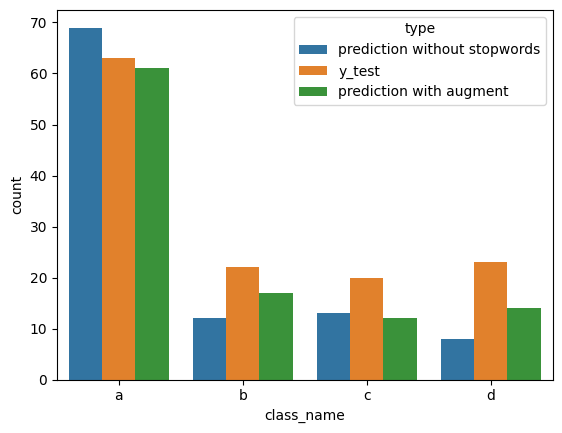

In [305]:
sns.barplot(data=test_plot, x= 'class_name', y ='count', hue = 'type')

In [309]:
print(classification_report(y_true= y_test,
                      y_pred = augmented_prediction))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        63
           1       0.88      0.68      0.77        22
           2       0.92      0.55      0.69        20
           3       1.00      0.61      0.76        23

   micro avg       0.95      0.77      0.85       128
   macro avg       0.94      0.69      0.79       128
weighted avg       0.95      0.77      0.84       128
 samples avg       0.91      0.82      0.84       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [316]:
mockup_text = """
A éviter si on attend quelque chose depuis longtemps ! J'ai précommandé un jeu que j'attendais depuis plus d'un an. J'ai payé une version Deluxe en supplément pour l'accès anticipé de 72h (sortie officielle le 10, accès anticipé le 7). 
Nous voilà le 8 après-midi, toujours rien reçu, un SAV certes très gentil mais qui hier me répond "ce sera livré cet après-midi, demain grand maximum". Sur le suivi de commande, commande "en préparation", alors que je devais être livrée hier (je n'aurais rien payé en supplément sinon !). Donc à éviter, car ne respectent absolument pas ce qui est noté sur leur site internet..."""

In [317]:
augmented_result['model'].predict(augmented_result['vectorizer'].transform([mockup_text]))

array([[0, 0, 1, 1]])

---

# A Priori Word Dictionary

In [764]:
BE_related_words = ['magasin', 'courses', 'achat' ,'caisse', 'stock', 
                    'manque', 'online', 'ligne', 'compte', 'disponible', 
                    'vendeur', 'rayon', 'market', 'marché', 'ville', 'connection',' connexion',
                    'enregistré', 'magasins', 'personnel', 'chez']


PD_related_words = ['produit', 'produits', 'frai', 'frais', 'fruit', 'fruits', 'légume', 'boucherie', 'prix', 'raisonable',
                    'raisonables', 'cher', 'bio', 'ordinateur', 'portable', 'bouteille', 'bouteilles','variétés',
                    'goût', ]
                    # 'pain', 'eau', 'viande' , 'kilo', 'kilos' ,'euro', 'euros']



DM_related_words = ['Drive', 'drive', 'livraison', 'livreur', 'livreurs', 'livraisons',
                    'coli', 'colis', 'récupère', 'récuperer' ,'récuperé', 'envoyé', 'commande',
                    'commmandes', 'arrivé', 'arrivée' ,'tard']

AS_related_words = ["service client",  "service clients", "Service client", "sav", "s.a.v.", "appel" , "remboursement",
                    "rembourser", 'après vente', "après-vente" ]

In [765]:
def count_be(text):
    count = 0 
    for word in BE_related_words:
        if word in text:
            count+=1

    return count

def count_dm(text):
    count = 0 
    for word in DM_related_words:
        if word in text:
            count+=1

    return count

def count_pd(text):
    count = 0 
    for word in PD_related_words:
        if word in text:
            count+=1

    return count

def count_as(text):
    count = 0 
    for word in AS_related_words:
        if word in text:
            count+=1

    return count


In [642]:
X = label_df['combined_reviews']
y = label_df.iloc[: , -7: -3]

X_train_text, X_test_text, y_train, y_test= train_test_split(X, y,
                                                              train_size=0.7,
                                                              random_state=42)

## Delivery Mode class

### Augmented classfication report

In [654]:
dm_dict_result= {}

In [657]:
augment_pred_dm = augmented_result['model'].predict(augmented_result['vectorizer'].transform(X_test_text))[: , 2]
augment_pred_dm_prob =  augmented_result['model'].predict_proba(augmented_result['vectorizer'].transform(X_test_text))[2]

print(classification_report(y_true = y_test.iloc[: ,2],
                            y_pred = augment_pred_dm))

dm_dict_result['augment_macro'] = f1_score(y_true = y_test.iloc[: ,2],
               y_pred = augment_pred_dm, average = 'macro').round(2)

dm_dict_result['augment_acc'] = accuracy_score(y_true = y_test.iloc[: ,2],
               y_pred = augment_pred_dm).round(2)

              precision    recall  f1-score   support

           0       0.87      0.98      0.93        63
           1       0.92      0.55      0.69        20

    accuracy                           0.88        83
   macro avg       0.89      0.77      0.81        83
weighted avg       0.88      0.88      0.87        83



### a priori word report

In [658]:
clf_dm = SVC(kernel='sigmoid', probability=True, C= 0.1)
clf_dm.fit(np.array(X_train_text.apply(lambda x : count_dm(x))).reshape(-1,1), 
        np.array(y_train.iloc[: , 2 ]))
svm_prediction_dm = clf_dm.predict(np.array(X_test_text.apply(lambda x : count_dm(x))).reshape(-1,1))
svm_prediction_prob_dm = clf_dm.predict_proba(np.array(X_test_text.apply(lambda x : count_dm(x))).reshape(-1,1))
print(classification_report(y_true = y_test.iloc[: , 2],
                            y_pred = svm_prediction_dm))

dm_dict_result['kw_macro'] = f1_score(y_true = y_test.iloc[: ,2],
               y_pred = svm_prediction_dm, average = 'macro').round(2)

dm_dict_result['kw_acc'] = accuracy_score(y_true = y_test.iloc[: ,2],
               y_pred = svm_prediction_dm).round(2)

              precision    recall  f1-score   support

           0       0.98      0.73      0.84        63
           1       0.53      0.95      0.68        20

    accuracy                           0.78        83
   macro avg       0.75      0.84      0.76        83
weighted avg       0.87      0.78      0.80        83



### Ensemble method

In [660]:
ensemble_prediction_dm = np.argmax((augment_pred_dm_prob + svm_prediction_prob_dm) / 2 , axis= 1)
print(classification_report(y_true = y_test.iloc[: , 2],
                            y_pred = ensemble_prediction_dm))


dm_dict_result['ensemble_macro'] = f1_score(y_true = y_test.iloc[: ,2],
               y_pred = ensemble_prediction_dm, average = 'macro').round(2)

dm_dict_result['ensemble_acc'] = accuracy_score(y_true = y_test.iloc[: ,2],
               y_pred = ensemble_prediction_dm).round(2)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        63
           1       0.94      0.80      0.86        20

    accuracy                           0.94        83
   macro avg       0.94      0.89      0.91        83
weighted avg       0.94      0.94      0.94        83



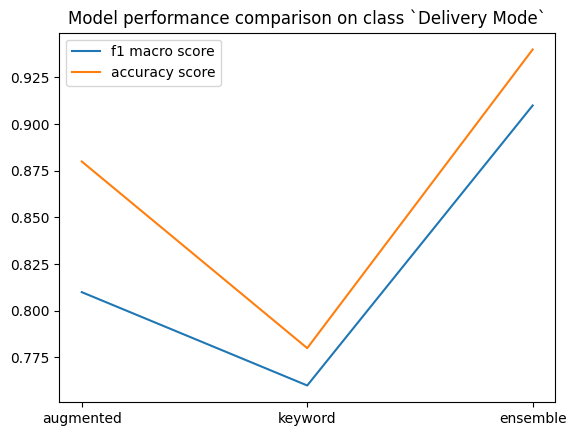

In [668]:
plt.plot(['augmented', 'keyword' , 'ensemble'] , [dm_dict_result['augment_macro'],
                             dm_dict_result['kw_macro'],
                             dm_dict_result['ensemble_macro']],
         label = 'f1 macro score')

plt.plot(['augmented', 'keyword' , 'ensemble'] , [dm_dict_result['augment_acc'],
                             dm_dict_result['kw_acc'],
                             dm_dict_result['ensemble_acc']],
          label = 'accuracy score')
plt.title('Model performance comparison on class `Delivery Mode`')
plt.legend()

## Product class

In [755]:
pd_dict_result= {}

### Augment report

In [756]:
augment_pred_pd = augmented_result['model'].predict(augmented_result['vectorizer'].transform(X_test_text))[: , 1]
augment_pred_pd_prob =  augmented_result['model'].predict_proba(augmented_result['vectorizer'].transform(X_test_text))[1]

print(classification_report(y_true = y_test.iloc[: ,1],
                            y_pred = augment_pred_pd))

pd_dict_result['augment_macro'] = f1_score(y_true = y_test.iloc[: ,1],
               y_pred = augment_pred_pd, average = 'macro').round(2)

pd_dict_result['augment_acc'] = accuracy_score(y_true = y_test.iloc[: ,1],
               y_pred = augment_pred_pd).round(2)

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        61
           1       0.88      0.68      0.77        22

    accuracy                           0.89        83
   macro avg       0.89      0.82      0.85        83
weighted avg       0.89      0.89      0.89        83



### Keyword report

In [757]:
# clf_pd = SVC(kernel='sigmoid', probability=True, C = 10)
# clf_pd = LogisticRegression()
clf_pd = GaussianNB(priors=[0.2, 0.8])
clf_pd.fit(np.array(X_train_text.apply(lambda x : count_pd(x))).reshape(-1,1), 
        np.array(y_train.iloc[: , 1 ]))
svm_prediction_pd = clf_pd.predict(np.array(X_test_text.apply(lambda x : count_pd(x))).reshape(-1,1))
svm_prediction_prob_pd = clf_pd.predict_proba(np.array(X_test_text.apply(lambda x : count_pd(x))).reshape(-1,1))
print(classification_report(y_true = y_test.iloc[: , 1],
                            y_pred = svm_prediction_pd))

pd_dict_result['kw_macro'] = f1_score(y_true = y_test.iloc[: ,1],
               y_pred = svm_prediction_pd, average = 'macro').round(2)

pd_dict_result['kw_acc'] = accuracy_score(y_true = y_test.iloc[: ,1],
               y_pred = svm_prediction_pd).round(2)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.27      1.00      0.42        22

    accuracy                           0.27        83
   macro avg       0.13      0.50      0.21        83
weighted avg       0.07      0.27      0.11        83



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

### Ensemble report

In [758]:
ensemble_prediction_pd = np.argmax((augment_pred_pd_prob + svm_prediction_prob_pd) / 2 , axis= 1)
print(classification_report(y_true = y_test.iloc[: , 1],
                            y_pred = ensemble_prediction_pd))


pd_dict_result['ensemble_macro'] = f1_score(y_true = y_test.iloc[: ,1],
               y_pred = ensemble_prediction_pd, average = 'macro').round(2)

pd_dict_result['ensemble_acc'] = accuracy_score(y_true = y_test.iloc[: ,1],
               y_pred = ensemble_prediction_pd).round(2)

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        61
           1       0.76      0.86      0.81        22

    accuracy                           0.89        83
   macro avg       0.85      0.88      0.87        83
weighted avg       0.90      0.89      0.89        83



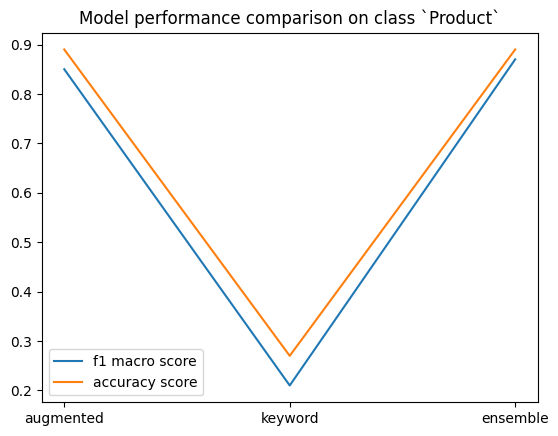

In [759]:
plt.plot(['augmented', 'keyword' , 'ensemble'] , [pd_dict_result['augment_macro'],
                             pd_dict_result['kw_macro'],
                             pd_dict_result['ensemble_macro']],
         label = 'f1 macro score')

plt.plot(['augmented', 'keyword' , 'ensemble'] , [pd_dict_result['augment_acc'],
                             pd_dict_result['kw_acc'],
                             pd_dict_result['ensemble_acc']],
          label = 'accuracy score')
plt.title('Model performance comparison on class `Product`')
plt.legend()

## After-Sales class

In [766]:
as_dict_result= {}

### Augmented method

In [767]:
augment_pred_as = augmented_result['model'].predict(augmented_result['vectorizer'].transform(X_test_text))[: , 3]
augment_pred_as_prob =  augmented_result['model'].predict_proba(augmented_result['vectorizer'].transform(X_test_text))[3]

print(classification_report(y_true = y_test.iloc[: ,3],
                            y_pred = augment_pred_as))

as_dict_result['augment_macro'] = f1_score(y_true = y_test.iloc[: ,3],
               y_pred = augment_pred_as, average = 'macro').round(2)

as_dict_result['augment_acc'] = accuracy_score(y_true = y_test.iloc[: ,3],
               y_pred = augment_pred_as).round(2)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        60
           1       1.00      0.61      0.76        23

    accuracy                           0.89        83
   macro avg       0.93      0.80      0.84        83
weighted avg       0.91      0.89      0.88        83



### Keyword method

In [776]:
clf_as = SVC(kernel='sigmoid', probability=True, C = 0.1)
# clf_pd = LogisticRegression()
clf_as.fit(np.array(X_train_text.apply(lambda x : count_as(x))).reshape(-1,1), 
        np.array(y_train.iloc[: , 3 ]))
svm_prediction_as = clf_as.predict(np.array(X_test_text.apply(lambda x : count_as(x))).reshape(-1,1))
svm_prediction_prob_as = clf_as.predict_proba(np.array(X_test_text.apply(lambda x : count_as(x))).reshape(-1,1))
print(classification_report(y_true = y_test.iloc[: , 3],
                            y_pred = svm_prediction_as))

as_dict_result['kw_macro'] = f1_score(y_true = y_test.iloc[: ,3],
               y_pred = svm_prediction_as, average = 'macro').round(2)

as_dict_result['kw_acc'] = accuracy_score(y_true = y_test.iloc[: ,3],
               y_pred = svm_prediction_as).round(2)

              precision    recall  f1-score   support

           0       0.87      0.77      0.81        60
           1       0.53      0.70      0.60        23

    accuracy                           0.75        83
   macro avg       0.70      0.73      0.71        83
weighted avg       0.78      0.75      0.76        83



### Ensemble method

In [777]:
ensemble_prediction_as = np.argmax((augment_pred_as_prob + svm_prediction_prob_as) / 2 , axis= 1)
print(classification_report(y_true = y_test.iloc[: , 3],
                            y_pred = ensemble_prediction_as))


as_dict_result['ensemble_macro'] = f1_score(y_true = y_test.iloc[: ,3],
               y_pred = ensemble_prediction_as, average = 'macro').round(2)

as_dict_result['ensemble_acc'] = accuracy_score(y_true = y_test.iloc[: ,3],
               y_pred = ensemble_prediction_as).round(2)

              precision    recall  f1-score   support

           0       0.89      0.98      0.94        60
           1       0.94      0.70      0.80        23

    accuracy                           0.90        83
   macro avg       0.92      0.84      0.87        83
weighted avg       0.91      0.90      0.90        83



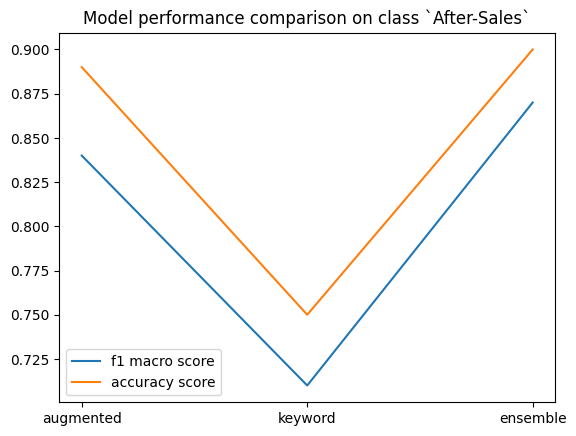

In [781]:
plt.plot(['augmented', 'keyword' , 'ensemble'] , [as_dict_result['augment_macro'],
                             as_dict_result['kw_macro'],
                             as_dict_result['ensemble_macro']],
         label = 'f1 macro score')

plt.plot(['augmented', 'keyword' , 'ensemble'] , [as_dict_result['augment_acc'],
                             as_dict_result['kw_acc'],
                             as_dict_result['ensemble_acc']],
          label = 'accuracy score')
plt.title('Model performance comparison on class `After-Sales`')
plt.legend()

# Let's combine everything

In [785]:
prediction_be = augmented_result['model'].predict(augmented_result['vectorizer'].transform(X_test_text))[: , 0]
print(prediction_be.shape)

(83,)


In [799]:
final_prediction = np.vstack([prediction_be, ensemble_prediction_pd,
                              ensemble_prediction_dm, ensemble_prediction_as]).T
print(final_prediction.shape)

(83, 4)


In [802]:
print(classification_report(y_true = y_test,
                            y_pred = final_prediction))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        63
           1       0.76      0.86      0.81        22
           2       0.94      0.80      0.86        20
           3       0.94      0.70      0.80        23

   micro avg       0.92      0.86      0.89       128
   macro avg       0.90      0.82      0.86       128
weighted avg       0.92      0.86      0.89       128
 samples avg       0.90      0.88      0.88       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [803]:
print(accuracy_score(y_true = y_test,
                            y_pred = final_prediction))

0.7349397590361446


In [807]:
print(accuracy_score(y_true = [0,0,1,0],
                            y_pred = [0,1,1,0]))

0.75


# Save every model 

In [810]:
augmented_result["model"]

MultiOutputClassifier(estimator=LogisticRegression())

In [811]:
import joblib

In [843]:
MODEL_CHECKPOINT_PAHT = "model_checkpoint/"

# CLF1 - classifier
# filename = "clf1_augmented_clf.sav"
# joblib.dump(augmented_result["model"], filename)

# CLF1 - tokenizer
# filename =  MODEL_CHECKPOINT_PAHT + "clf1_augmented_vectorizer.sav"
# joblib.dump(augmented_result["vectorizer"], filename)

#CLF2 - Product
filename_clf2_pd =  MODEL_CHECKPOINT_PAHT + "clf2-product-clf.sav"
filename_clf2_dm =  MODEL_CHECKPOINT_PAHT + "clf2-delivery-clf.sav"
filename_clf2_as =  MODEL_CHECKPOINT_PAHT + "clf2-aftersales-clf.sav"

joblib.dump(clf_pd, filename_clf2_pd)
joblib.dump(clf_dm, filename_clf2_dm)
joblib.dump(clf_as, filename_clf2_as)


['model_checkpoint/clf2-aftersales-clf.sav']

In [844]:
clf1_loaded_clf = joblib.load("model_checkpoint/clf1_augmented_clf.sav")
clf1_loaded_vectorizer = joblib.load("model_checkpoint/clf1_augmented_vectorizer.sav")


clf2_loaded_clf_pd = joblib.load("model_checkpoint/clf2-product-clf.sav")
clf2_loaded_clf_dm = joblib.load("model_checkpoint/clf2-delivery-clf.sav")
clf2_loaded_clf_as = joblib.load("model_checkpoint/clf2-aftersales-clf.sav")

## Calling the first pipeline prediction

In [840]:
clf1_loaded_prediction = clf1_loaded_clf.predict(clf1_loaded_vectorizer.transform(X_test_text))
print(classification_report(y_true = y_test,
                            y_pred = clf1_loaded_prediction))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        63
           1       0.88      0.68      0.77        22
           2       0.92      0.55      0.69        20
           3       1.00      0.61      0.76        23

   micro avg       0.95      0.77      0.85       128
   macro avg       0.94      0.69      0.79       128
weighted avg       0.95      0.77      0.84       128
 samples avg       0.91      0.82      0.84       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1038]:
for c in range(4):
    if c == 0:
        print("class - Buying experience")
        be_prediction = clf1_loaded_clf.predict(clf1_loaded_vectorizer.transform(X_test_text))[: , 0]
        
    elif c == 1:
        print("class - Product")
        clf1_pd_prediction_proba = clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_test_text))[c]
        clf2_pd_prediction_proba = clf2_loaded_clf_pd.predict_proba(np.array(X_test_text.apply(lambda x : count_pd(x))).reshape(-1,1))
        final_prediction_pd = np.argmax((clf1_pd_prediction_proba + clf2_pd_prediction_proba) / 2, axis =1)
        assert np.all([ensemble_prediction_pd == final_prediction_pd])
        
    elif c == 2:
        print("class - Delivery")
        clf1_dm_prediction_proba = clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_test_text))[c]
        clf2_dm_prediction_proba = clf2_loaded_clf_dm.predict_proba(np.array(X_test_text.apply(lambda x : count_dm(x))).reshape(-1,1))
        final_prediction_dm = np.argmax((clf1_dm_prediction_proba + clf2_dm_prediction_proba) / 2, axis =1)
        assert np.all([ensemble_prediction_dm == final_prediction_dm])
        
    elif c == 3:
        print("class - AfterSales")
        clf1_as_prediction_proba = clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_test_text))[c]
        clf2_as_prediction_proba = clf2_loaded_clf_as.predict_proba(np.array(X_test_text.apply(lambda x : count_as(x))).reshape(-1,1))
        final_prediction_as = np.argmax((clf1_as_prediction_proba + clf2_as_prediction_proba) / 2, axis =1)
        assert np.all([ensemble_prediction_as == final_prediction_as])

class - Buying experience
class - Product
class - Delivery
class - AfterSales


In [1044]:
new_final_prediction = np.vstack([be_prediction, final_prediction_pd , final_prediction_dm, final_prediction_as ]).T
print(np.all(new_final_prediction == final_prediction))

True


In [1057]:
new_X_train[:3 ,:]

array([[0.02539653, 0.97460347, 0.97893823, 0.02106177, 0.98551097,
        0.01448903, 0.97756528, 0.02243472, 0.31552846, 0.68447154,
        0.93818625, 0.06181375, 0.89078832, 0.10921168],
       [0.94827618, 0.05172382, 0.96512029, 0.03487971, 0.07793862,
        0.92206138, 0.95878259, 0.04121741, 0.31552846, 0.68447154,
        0.21495361, 0.78504639, 0.89078832, 0.10921168],
       [0.13267656, 0.86732344, 0.95106783, 0.04893217, 0.0524842 ,
        0.9475158 , 0.94369783, 0.05630217, 0.26476458, 0.73523542,
        0.21495361, 0.78504639, 0.89078832, 0.10921168]])

In [1051]:
haha  = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=10, 
                                            activation='relu', alpha=0.01,
                                            learning_rate_init=0.001,
                                            learning_rate='adaptive',
                                            max_iter=10000)).fit(new_X_train, y_train)
haha_prediction = haha.predict(new_X_test)

print(classification_report(y_test,
                            haha_prediction))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.94      0.68      0.79        22
           2       0.92      0.55      0.69        20
           3       0.94      0.65      0.77        23

   micro avg       0.95      0.80      0.87       128
   macro avg       0.94      0.72      0.81       128
weighted avg       0.95      0.80      0.86       128
 samples avg       0.94      0.85      0.88       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1043]:
new_X_train = np.hstack([clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_train_text))[0],
           clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_train_text))[1],
           clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_train_text))[2],
           clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_train_text))[3],
           clf2_loaded_clf_pd.predict_proba(np.array(X_train_text.apply(lambda x : count_pd(x))).reshape(-1,1)),
           clf2_loaded_clf_dm.predict_proba(np.array(X_train_text.apply(lambda x : count_dm(x))).reshape(-1,1)),
           clf2_loaded_clf_as.predict_proba(np.array(X_train_text.apply(lambda x : count_as(x))).reshape(-1,1))
]
)


new_X_test = np.hstack([clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_test_text))[0],
           clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_test_text))[1],
           clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_test_text))[2],
           clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_test_text))[3],
           clf2_loaded_clf_pd.predict_proba(np.array(X_test_text.apply(lambda x : count_pd(x))).reshape(-1,1)),
           clf2_loaded_clf_dm.predict_proba(np.array(X_test_text.apply(lambda x : count_dm(x))).reshape(-1,1)),
           clf2_loaded_clf_as.predict_proba(np.array(X_test_text.apply(lambda x : count_as(x))).reshape(-1,1))
]
)

assert new_X_train.shape[1] == new_X_test.shape[1]

In [940]:
from sklearn.neural_network import MLPClassifier

In [996]:
haha  = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=10, 
                                            activation='relu', alpha=0.0001,
                                            learning_rate_init=0.03,
                                            learning_rate='adaptive',
                                            max_iter=1000)).fit(new_X_train, y_train)
haha_prediction = haha.predict(new_X_test)

In [997]:
print(classification_report(y_test,
                            haha_prediction))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91        63
           1       0.88      0.64      0.74        22
           2       0.92      0.55      0.69        20
           3       0.95      0.78      0.86        23

   micro avg       0.94      0.76      0.84       128
   macro avg       0.93      0.71      0.80       128
weighted avg       0.94      0.76      0.83       128
 samples avg       0.86      0.79      0.81       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [898]:
clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_train_text))[1].shape

(193, 2)

In [899]:
clf2_loaded_clf_as.predict_proba(np.array(X_train_text.apply(lambda x : count_as(x))).reshape(-1,1))

array([[0.89078832, 0.10921168],
       [0.89078832, 0.10921168],
       [0.89078832, 0.10921168],
       [0.21448629, 0.78551371],
       [0.21448629, 0.78551371],
       [0.89078832, 0.10921168],
       [0.89078832, 0.10921168],
       [0.89078832, 0.10921168],
       [0.89078832, 0.10921168],
       [0.89078832, 0.10921168],
       [0.89078832, 0.10921168],
       [0.21448629, 0.78551371],
       [0.89078832, 0.10921168],
       [0.89078832, 0.10921168],
       [0.21543153, 0.78456847],
       [0.21543153, 0.78456847],
       [0.21448629, 0.78551371],
       [0.21448629, 0.78551371],
       [0.89078832, 0.10921168],
       [0.89078832, 0.10921168],
       [0.21448629, 0.78551371],
       [0.89078832, 0.10921168],
       [0.21448629, 0.78551371],
       [0.21448629, 0.78551371],
       [0.89078832, 0.10921168],
       [0.21448629, 0.78551371],
       [0.21448629, 0.78551371],
       [0.21563231, 0.78436769],
       [0.89078832, 0.10921168],
       [0.89078832, 0.10921168],
       [0.

In [1001]:
for c in range(4):
    if c == 0:
        print("class - Buying experience")
        be_prediction = clf1_loaded_clf.predict(clf1_loaded_vectorizer.transform(X_test_text))[: , 0]
        
    elif c == 1:
        print("class - Product")
        clf1_pd_prediction_proba = clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_test_text))[c]
        clf2_pd_prediction_proba = clf2_loaded_clf_pd.predict_proba(np.array(X_test_text.apply(lambda x : count_pd(x))).reshape(-1,1))
        final_prediction_pd = np.argmax((clf1_pd_prediction_proba + clf2_pd_prediction_proba) / 2, axis =1)
        assert np.all([ensemble_prediction_pd == final_prediction_pd])
        
    elif c == 2:
        print("class - Delivery")
        clf1_dm_prediction_proba = clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_test_text))[c]
        clf2_dm_prediction_proba = clf2_loaded_clf_dm.predict_proba(np.array(X_test_text.apply(lambda x : count_dm(x))).reshape(-1,1))
        final_prediction_dm = np.argmax((clf1_dm_prediction_proba + clf2_dm_prediction_proba) / 2, axis =1)
        assert np.all([ensemble_prediction_dm == final_prediction_dm])
        
    elif c == 3:
        print("class - AfterSales")
        clf1_as_prediction_proba = clf1_loaded_clf.predict_proba(clf1_loaded_vectorizer.transform(X_test_text))[c]
        clf2_as_prediction_proba = clf2_loaded_clf_as.predict_proba(np.array(X_test_text.apply(lambda x : count_as(x))).reshape(-1,1))
        final_prediction_as = np.argmax((clf1_as_prediction_proba + clf2_as_prediction_proba) / 2, axis =1)
        assert np.all([ensemble_prediction_as == final_prediction_as])

class - Buying experience
class - Product
class - Delivery
class - AfterSales


In [999]:
be_prediction

array([], dtype=int64)

In [1058]:
new_X_train = np.vstack([clf1_loaded_clf.predict(clf1_loaded_vectorizer.transform(X_train_text))[: ,0],
           clf1_loaded_clf.predict(clf1_loaded_vectorizer.transform(X_train_text))[:, 1],
           clf1_loaded_clf.predict(clf1_loaded_vectorizer.transform(X_train_text))[:, 2],
           clf1_loaded_clf.predict(clf1_loaded_vectorizer.transform(X_train_text))[:, 3],
           clf2_loaded_clf_pd.predict(np.array(X_train_text.apply(lambda x : count_pd(x))).reshape(-1,1)),
           clf2_loaded_clf_dm.predict(np.array(X_train_text.apply(lambda x : count_dm(x))).reshape(-1,1)),
           clf2_loaded_clf_as.predict(np.array(X_train_text.apply(lambda x : count_as(x))).reshape(-1,1))
]
).T


new_X_test = np.vstack([clf1_loaded_clf.predict(clf1_loaded_vectorizer.transform(X_test_text))[:, 0],
           clf1_loaded_clf.predict(clf1_loaded_vectorizer.transform(X_test_text))[:, 1],
           clf1_loaded_clf.predict(clf1_loaded_vectorizer.transform(X_test_text))[:, 2],
           clf1_loaded_clf.predict(clf1_loaded_vectorizer.transform(X_test_text))[: ,3],
           clf2_loaded_clf_pd.predict(np.array(X_test_text.apply(lambda x : count_pd(x))).reshape(-1,1)),
           clf2_loaded_clf_dm.predict(np.array(X_test_text.apply(lambda x : count_dm(x))).reshape(-1,1)),
           clf2_loaded_clf_as.predict(np.array(X_test_text.apply(lambda x : count_as(x))).reshape(-1,1))
]
).T

assert new_X_train.shape[1] == new_X_test.shape[1]

In [1018]:
new_X_train

array([[1, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 1, 0],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 1, 0]])

In [1071]:
haha  = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=10, 
                                            activation='relu', alpha=0.0001,
                                            learning_rate_init=0.001,
                                            learning_rate='adaptive',
                                            max_iter=1000)).fit(new_X_train, y_train)
haha_prediction = haha.predict(new_X_test)
print(classification_report(y_test,
                            haha_prediction))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        63
           1       0.88      0.68      0.77        22
           2       0.85      0.55      0.67        20
           3       1.00      0.61      0.76        23

   micro avg       0.94      0.77      0.85       128
   macro avg       0.92      0.69      0.79       128
weighted avg       0.94      0.77      0.84       128
 samples avg       0.91      0.82      0.84       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1060]:
haha  = MultiOutputClassifier(MultinomialNB()).fit(new_X_train, y_train)
haha_prediction = haha.predict(new_X_test)
print(classification_report(y_test,
                            haha_prediction))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91        63
           1       0.88      0.68      0.77        22
           2       0.85      0.55      0.67        20
           3       1.00      0.61      0.76        23

   micro avg       0.87      0.80      0.83       128
   macro avg       0.89      0.71      0.78       128
weighted avg       0.88      0.80      0.82       128
 samples avg       0.89      0.85      0.84       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1030]:
print(classification_report(y_test,
                            haha_prediction))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        63
           1       0.88      0.68      0.77        22
           2       0.92      0.55      0.69        20
           3       1.00      0.61      0.76        23

   micro avg       0.95      0.77      0.85       128
   macro avg       0.94      0.69      0.79       128
weighted avg       0.95      0.77      0.84       128
 samples avg       0.91      0.82      0.84       128



/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carlosito/Documents/Virtual_Environment/hexamind/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1073]:
for sssss in range(5):
    print("sth")
    print(sssss)

NameError: name 'dsd' is not defined